In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


PROBLEM STATEMENT:  What features of a property should I be looking at, if I want to make as high a sale as possible?  My regression model, which is will be a 

## Getting started, cleaning up
Doing test and train side by side

In [256]:
train_df = pd.read_csv('datasets/train.csv')

In [257]:
test_df = pd.read_csv('datasets/test.csv')

In [258]:
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [259]:
test_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [260]:
train_df.shape

(2051, 81)

In [261]:
test_df.shape

(878, 80)

Going through, cleaning up stuff and figuring out where nulls are.  

In [262]:
train_df.isna().sum()[50:80]

Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Pool QC           2042
Fence             1651
Misc Feature      1986
Misc Val             0
Mo Sold              0
Yr Sold              0
Sale Type            0
dtype: int64

Changing all relevant ordinal values to numbers from 1-5.

In [263]:
train_df.replace(['Ex','Go','TA','Fa','Po', 'Gd'], [5,4,3,2,1,3], inplace = True)
test_df.replace(['Ex','Go','TA','Fa','Po', 'Gd'], [5,4,3,2,1,3], inplace = True)

Putting 0s in ordinal values where those values are only missing because there is no garage/pool/fireplace/basement to score.  Treating have no basement as equal to having a bad basement. (something to examine later, maybe this will improve my model?)

In [264]:
train_df['Pool QC'].fillna(0, inplace = True)
test_df['Pool QC'].fillna(0, inplace = True)

In [265]:
train_df['Garage Qual'].fillna(0, inplace = True)
test_df['Garage Qual'].fillna(0, inplace = True)

In [266]:
train_df['Garage Cond'].fillna(0, inplace = True)
test_df['Garage Cond'].fillna(0, inplace = True)

In [267]:
train_df['Fireplace Qu'].fillna(0, inplace = True)
test_df['Fireplace Qu'].fillna(0, inplace = True)

In [268]:
train_df['Bsmt Cond'].fillna(0, inplace = True)
test_df['Bsmt Cond'].fillna(0, inplace = True)

In [269]:
train_df['Bsmt Qual'].fillna(0, inplace = True)
test_df['Bsmt Qual'].fillna(0, inplace = True)

In [270]:
train_df.isna().sum()
test_df.isna().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    160
               ... 
Misc Feature    837
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
Length: 80, dtype: int64

Changed all the columns with this scale of Ex to NA to a scale of 5 to 0.

In [271]:
train_df.shape

(2051, 81)

In [272]:
train_df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [273]:
#lets pick some features, based on the data dict.
#lot frontage! lot area! Overall Qual! Overall Cond! Year Built, Year Remod/Add, all the SFs, the room counts, total rooms above ground, Fireplaces, garage year built and cars and area, deck values and pool values, 

Renaming everything to snake_case.

In [274]:
train_df.rename(columns = 
                {'Id':'id',
               'Lot Frontage':'lot_frontage',
               'Lot Area':'lot_area',
               'Overall Qual':'overall_qual',
               'Overall Cond':'overall_cond',
               'Year Built':'year_built',
               'Year Remod/Add':'year_remod_add',
                'Bsmt Qual':'bsmt_qual',
                'Bsmt Cond':'bsmt_cond',
                'Total Bsmt SF':'total_bsmt_sf',
                '1st Flr SF':'1st_flr_sf',
                '2nd Flr SF':'2nd_flr_sf',
                'Low Qual Fin SF':'low_qual_fin_sf',
                'Bsmt Full Bath':'bsmt_full_bath',
               'Bsmt Half Bath':'bsmt_half_bath',
                'Full Bath':'full_bath', 
                'Half Bath':'half_bath', 
                'Bedroom AbvGr':'bedroom_abv_gr',
               'Kitchen AbvGr':'kitchen_abv_gr', 
                'Kitchen Qual':'kitchen_qual', 
                'TotRms AbvGrd':'tot_rms_abv_grd',
                'Fireplaces':'fireplaces',
                'Fireplace Qu':'fireplace_qual',
                'Garage Yr Built':'garage_yr_built',
                'Garage Cars':'garage_car_cap',
                'Garage Area':'garage_area',
                'Garage Qual':'garage_qual',
                'Garage Cond':'garage_cond',
                'Wood Deck SF':'wood_deck_sf',
                'Open Porch SF':'open_porch_sf',
               'Enclosed Porch':'enclosed_porch_sf',
                '3Ssn Porch':'3_season_porch_sf', 
                'Screen Porch':'screen_porch', 
                'Pool Area':'pool_area', 
                'Pool QC':'pool_qual',
                'SalePrice':'sale_price'},
                inplace = True
               )

test_df.rename(columns = 
                {'Id':'id',
               'Lot Frontage':'lot_frontage',
               'Lot Area':'lot_area',
               'Overall Qual':'overall_qual',
               'Overall Cond':'overall_cond',
               'Year Built':'year_built',
               'Year Remod/Add':'year_remod_add',
                'Bsmt Qual':'bsmt_qual',
                'Bsmt Cond':'bsmt_cond',
                'Total Bsmt SF':'total_bsmt_sf',
                '1st Flr SF':'1st_flr_sf',
                '2nd Flr SF':'2nd_flr_sf',
                'Low Qual Fin SF':'low_qual_fin_sf',
                'Bsmt Full Bath':'bsmt_full_bath',
               'Bsmt Half Bath':'bsmt_half_bath',
                'Full Bath':'full_bath', 
                'Half Bath':'half_bath', 
                'Bedroom AbvGr':'bedroom_abv_gr',
               'Kitchen AbvGr':'kitchen_abv_gr', 
                'Kitchen Qual':'kitchen_qual', 
                'TotRms AbvGrd':'tot_rms_abv_grd',
                'Fireplaces':'fireplaces',
                'Fireplace Qu':'fireplace_qual',
                'Garage Yr Built':'garage_yr_built',
                'Garage Cars':'garage_car_cap',
                'Garage Area':'garage_area',
                'Garage Qual':'garage_qual',
                'Garage Cond':'garage_cond',
                'Wood Deck SF':'wood_deck_sf',
                'Open Porch SF':'open_porch_sf',
               'Enclosed Porch':'enclosed_porch_sf',
                '3Ssn Porch':'3_season_porch_sf', 
                'Screen Porch':'screen_porch', 
                'Pool Area':'pool_area', 
                'Pool QC':'pool_qual',
                'SalePrice':'sale_price'},
                inplace = True
               )

Selecting what columns I want to build my model around.  Can add more later, if necessary.  Only focusing on cleaning up these, from here on out.

In [275]:
featured_columns = train_df.filter(['id',
                            'lot_frontage',
                            'lot_area',
                            'overall_qual',
                            'overall_cond',
                            'year_built',
                            'year_remod_add',
                            'bsmt_qual',
                            'bsmt_cond',
                            'total_bsmt_sf',
                            '1st_flr_sf',
                            '2nd_flr_sf',
                            'low_qual_fin_sf',
                            'bsmt_full_bath',
                            'bsmt_half_bath',
                            'full_bath', 
                            'half_bath', 
                            'bedroom_abv_gr',
                            'kitchen_abv_gr', 
                            'kitchen_qual',
                            'tot_rms_abv_grd',
                            'fireplaces',
                            'fireplace_qual',
                            'garage_yr_built',
                            'garage_car_cap',
                            'garage_area',
                            'garage_qual',
                            'garage_cond',
                            'wood_deck_sf',
                            'open_porch_sf',
                            'enclosed_porch_sf',
                            '3_season_porch_sf',
                            'screen_porch',
                            'pool_area',
                            'pool_qual',
                            'sale_price'],
                           axis = 1)

In [276]:
featured_columns.shape

(2051, 35)

Got rid of a bunch of columns that, for now, are too much work for me to handle.  Gonna operate on just these 35, and that should be enough to get us a good model.

In [277]:
featured_columns.isna().sum()

id                     0
lot_frontage         330
lot_area               0
overall_qual           0
overall_cond           0
year_built             0
year_remod_add         0
bsmt_qual              0
bsmt_cond              0
total_bsmt_sf          1
1st_flr_sf             0
2nd_flr_sf             0
low_qual_fin_sf        0
bsmt_full_bath         2
bsmt_half_bath         2
full_bath              0
half_bath              0
bedroom_abv_gr         0
kitchen_abv_gr         0
kitchen_qual           0
tot_rms_abv_grd        0
fireplaces             0
fireplace_qual         0
garage_car_cap         1
garage_area            1
garage_qual            0
garage_cond            0
wood_deck_sf           0
open_porch_sf          0
enclosed_porch_sf      0
3_season_porch_sf      0
screen_porch           0
pool_area              0
pool_qual              0
sale_price             0
dtype: int64

In [278]:
featured_columns.fillna(0,inplace = True)

In [279]:
test_df.fillna(0, inplace = True)

Fixing nulls!  Justifying these as, again, if it's a 0 it means there isn't one at all.  Having no street frontage for the house is the same as having 0.

In [280]:
featured_columns.isna().sum()

id                   0
lot_frontage         0
lot_area             0
overall_qual         0
overall_cond         0
year_built           0
year_remod_add       0
bsmt_qual            0
bsmt_cond            0
total_bsmt_sf        0
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
bsmt_full_bath       0
bsmt_half_bath       0
full_bath            0
half_bath            0
bedroom_abv_gr       0
kitchen_abv_gr       0
kitchen_qual         0
tot_rms_abv_grd      0
fireplaces           0
fireplace_qual       0
garage_car_cap       0
garage_area          0
garage_qual          0
garage_cond          0
wood_deck_sf         0
open_porch_sf        0
enclosed_porch_sf    0
3_season_porch_sf    0
screen_porch         0
pool_area            0
pool_qual            0
sale_price           0
dtype: int64

In [281]:
featured_columns.dtypes

id                     int64
lot_frontage         float64
lot_area               int64
overall_qual           int64
overall_cond           int64
year_built             int64
year_remod_add         int64
bsmt_qual            float64
bsmt_cond            float64
total_bsmt_sf        float64
1st_flr_sf             int64
2nd_flr_sf             int64
low_qual_fin_sf        int64
bsmt_full_bath       float64
bsmt_half_bath       float64
full_bath              int64
half_bath              int64
bedroom_abv_gr         int64
kitchen_abv_gr         int64
kitchen_qual           int64
tot_rms_abv_grd        int64
fireplaces             int64
fireplace_qual       float64
garage_car_cap       float64
garage_area          float64
garage_qual          float64
garage_cond          float64
wood_deck_sf           int64
open_porch_sf          int64
enclosed_porch_sf      int64
3_season_porch_sf      int64
screen_porch           int64
pool_area              int64
pool_qual            float64
sale_price    

No nulls!  All numbers!  Good for now.  Let's start some feature engineering.  As of now, with the model below, I've got a Kaggle score of 38363.  Let's make that a little better with some more features.

## Feature Engineering
Pairplot first!


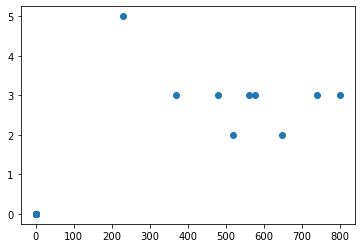

In [282]:
plt.scatter(featured_columns['pool_area'],featured_columns['pool_qual'])

Ooooh, seems like there's a relationship between 'pool area' and 'pool quality'.  let's make that interaction term a column.

In [283]:
featured_columns['pool_area * pool_qual'] = featured_columns['pool_area'] * featured_columns['pool_qual']
test_df['pool_area * pool_qual'] = test_df['pool_area'] * test_df['pool_qual']

Let's find at least one more interaction term we can use.

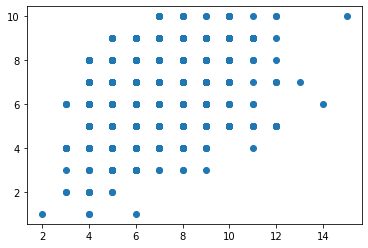

In [284]:
plt.scatter(featured_columns['tot_rms_abv_grd'], featured_columns['overall_qual'])

Sweet.  Looks like the more rooms we have above ground, the better our overall quality score is.

In [285]:
featured_columns['tot_rms_abv_grd * overall_qual'] = featured_columns['tot_rms_abv_grd'] * featured_columns['overall_qual']
test_df['tot_rms_abv_grd * overall_qual'] = test_df['tot_rms_abv_grd'] * test_df['overall_qual']

Hmm.  With the new interaction terms included, and submitting to Kaggle, that only served to worsen my score. Calling it here, not adding any more noise.

## Let's build a model (using Riley's tips from the 14th)

In [286]:
X = featured_columns.drop(columns = ['id','sale_price'])
features = list(X.columns)
y = featured_columns['sale_price']

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [288]:
y_test_log = y_test.map(np.log)
y_train_log = y_train.map(np.log)

Building our linear regression model with our target logarithm-ized.  (I've since gone back over this, and removed the logging.  I get a better score without it, actually!)

In [289]:
lr = LinearRegression()
lr.fit(X_train, y_train)
log_lr = LinearRegression()
log_lr.fit(X_train, y_train_log)

LinearRegression()

In [315]:
pred = lr.predict(X_test)
log_pred = log_lr.predict(X_test)

In [316]:
residuals = y_test - pred
log_residuals = y_test - log_pred

<AxesSubplot:>

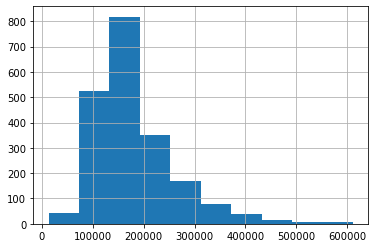

In [310]:
y.hist()

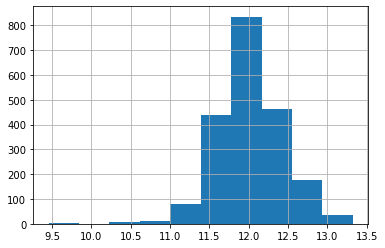

In [293]:
y.map(np.log).hist();

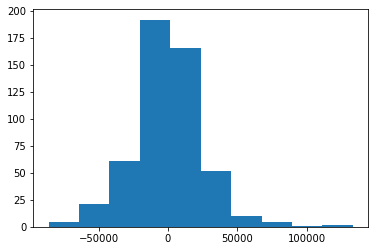

In [294]:
plt.hist(residuals);

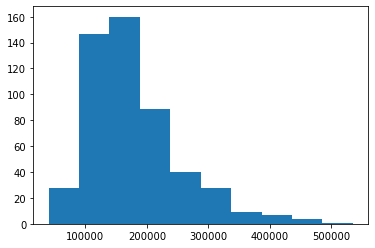

In [318]:
plt.hist(log_residuals);

In [295]:
#normal dist

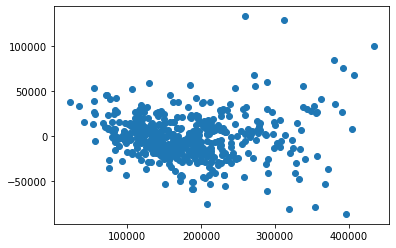

In [296]:
plt.scatter(pred, residuals);

Not particularly homescedastic, but the bias isn't horrible.

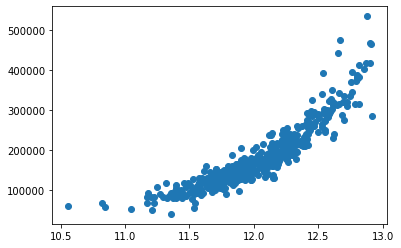

In [320]:
plt.scatter(log_pred, log_residuals);

A strong bias, but it is homescedastic.  This graph slides around, depending on the random state of our train test split.  Retains the bias and homoscedasticity though.


These scores are gonne be a touch wacky, thanks to the linear regression model being fit to a logarithmi

In [299]:
lr.score(X_train, y_train)

0.8453892915308674

In [321]:
log_lr.score(X_train, y_train)

-5.103395069814396

In [300]:
lr.score(X_test, y_test)

0.8899812727254054

In [322]:
log_lr.score(X_test, y_test)

-5.7298654814604895

In [326]:
r2_score(y_test, pred)

0.8899812727254054

In [325]:
log_pred_prices = np.exp(log_pred)

In [327]:
r2_score(y_test, log_pred_prices)

0.8930831099830414

In [ ]:
test_df[features].isnull().sum()

In [304]:
test_pred = lr.predict(test_df[features])

In [306]:
#test_df['sale_price'] = np.exp(test_pred)
test_df['sale_price'] =test_pred
test_df['SalePrice'] = test_df['sale_price']

In [307]:
test_df[['id', 'SalePrice']].to_csv('submission.csv', index=False)

Model built, and submitted!  Got a decent score, too!

## Visualization Time!

This is a bit of a gimme, but let's see what the relationship between overall quality of a property and it's sale price is!

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Property Quality to Sale Price')
plt.xlabel('Overall Quality Score')
plt.ylabel('Sale Price (USD)')
plt.scatter(train_df['overall_qual'], train_df['sale_price']);

Like I said, a gimme.  Of course the quality of a property will increase how much it sells for!  But maybe we can see some interesting correlations between property quality and other features of our dataset.